<a href="https://colab.research.google.com/github/wwwlovecom/my_rep/blob/main/(%D0%BF%D1%80%D0%B8%D1%81%D1%83%D1%82%D0%BD%D1%8F_%D0%BD%D0%B0_%D0%BF%D0%B0%D1%80%D1%96)_%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0_%D1%80%D0%BE%D0%B1%D0%BE%D1%82%D0%B0_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.5.1

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [3]:
print("Spark version:", spark.version)

Spark version: 3.5.1


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dinnymathew/usstockprices")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/usstockprices


In [5]:
data = spark.read.csv(
    path + '/stocks_price_final.csv',
    sep=',',
    header=True,
    inferSchema=True  # Додано для автоматичного визначення типів колонок
)

data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: date (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [6]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType, DateType


data_schema = [
               StructField('_c0', IntegerType(), True),
               StructField('symbol', StringType(), True),
               StructField('data', DateType(), True),
               StructField('open', DoubleType(), True),
               StructField('high', DoubleType(), True),
               StructField('low', DoubleType(), True),
               StructField('close', DoubleType(), True),
               StructField('volume', IntegerType(), True),
               StructField('adjusted', DoubleType(), True),
               StructField('market.cap', StringType(), True),
               StructField('sector', StringType(), True),
               StructField('industry', StringType(), True),
               StructField('exchange', StringType(), True),
            ]

final_struc = StructType(fields = data_schema)

data = spark.read.csv(
    path + '/stocks_price_final.csv',
    sep=',',
    header=True,
    inferSchema=True  # Додано для автоматичного визначення типів колонок
)

data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: date (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [7]:
data.columns

['_c0',
 'symbol',
 'date',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'adjusted',
 'market.cap',
 'sector',
 'industry',
 'exchange']

In [8]:
data = data.withColumn('date_1', data.date)

data.show(5)

+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+----------+
|_c0|symbol|      date|     open|     high|      low|    close| volume| adjusted|market.cap|       sector|            industry|exchange|    date_1|
+---+------+----------+---------+---------+---------+---------+-------+---------+----------+-------------+--------------------+--------+----------+
|  1|   TXG|2019-09-12|       54|       58|       51|    52.75|7326300|    52.75|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2019-09-12|
|  2|   TXG|2019-09-13|    52.75|   54.355|49.150002|    52.27|1025200|    52.27|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2019-09-13|
|  3|   TXG|2019-09-16|52.450001|       56|52.009998|55.200001| 269900|55.200001|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2019-09-16|
|  4|   TXG|2019-09-17|56.209999|60.900002|   55.423|56.779999| 602800|56.779999|    $9.31B|Capital Goods|Biotec

In [9]:
from pyspark.sql import functions as f

# 1. Видалення рядків з пропущеними значеннями
#data = data.na.drop()

# 2. Заповнення пропущених значень у колонці 'open' середнім
mean_open = data.select(f.mean('open')).collect()[0][0]
data = data.na.fill({'open': mean_open})

# 3. Заміна 'Unknown' на 'Technology' у колонці 'sector'
data = data.na.replace('Unknown', 'Technology', subset=['sector'])

In [10]:
# Вібір одного стовпця
data.select('sector').show(5)

# Вибір декількох стовпців
data.select(['open', 'close', 'adjusted']).show(5)

+-------------+
|       sector|
+-------------+
|Capital Goods|
|Capital Goods|
|Capital Goods|
|Capital Goods|
|Capital Goods|
+-------------+
only showing top 5 rows

+---------+---------+---------+
|     open|    close| adjusted|
+---------+---------+---------+
|       54|    52.75|    52.75|
|    52.75|    52.27|    52.27|
|52.450001|55.200001|55.200001|
|56.209999|56.779999|56.779999|
|56.849998|       62|       62|
+---------+---------+---------+
only showing top 5 rows



In [11]:
from pyspark.sql.functions import col

data.filter(
    (col('date') >= '2020-01-01') & (col('date') <= '2020-01-31')
).show(5)

+---+------+----------+---------+---------+---------+---------+------+---------+----------+-------------+--------------------+--------+----------+
|_c0|symbol|      date|     open|     high|      low|    close|volume| adjusted|market.cap|       sector|            industry|exchange|    date_1|
+---+------+----------+---------+---------+---------+---------+------+---------+----------+-------------+--------------------+--------+----------+
| 78|   TXG|2020-01-02|76.910004|77.989998|71.480003|72.830002|220200|72.830002|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2020-01-02|
| 79|   TXG|2020-01-03|71.519997|76.188004|70.580002|75.559998|288300|75.559998|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2020-01-03|
| 80|   TXG|2020-01-06|75.269997|77.349998|73.559998|75.550003|220600|75.550003|    $9.31B|Capital Goods|Biotechnology: La...|  NASDAQ|2020-01-06|
| 81|   TXG|2020-01-07|       76|77.279999|    75.32|75.980003|182400|75.980003|    $9.31B|Capital Goods|Biotechnology

In [12]:
from pyspark.sql import functions as f

data.select(
    'open',
    'close',
    f.when(data.adjusted >= 200.0, 1).otherwise(0).alias('high_adjusted_flag')
).show(5)

+---------+---------+------------------+
|     open|    close|high_adjusted_flag|
+---------+---------+------------------+
|       54|    52.75|                 0|
|    52.75|    52.27|                 0|
|52.450001|55.200001|                 0|
|56.209999|56.779999|                 0|
|56.849998|       62|                 0|
+---------+---------+------------------+
only showing top 5 rows



In [13]:
data.select(
    'sector',
    data.sector.rlike('^[B,C]').alias('Колонка sector починається з B або C')
).distinct().show()

+--------------------+------------------------------------+
|              sector|Колонка sector починається з B або C|
+--------------------+------------------------------------+
|         Health Care|                               false|
|       Capital Goods|                                true|
|Consumer Non-Dura...|                                true|
|    Public Utilities|                               false|
|   Consumer Durables|                                true|
|             Finance|                               false|
|      Transportation|                               false|
|       Miscellaneous|                               false|
|   Consumer Services|                                true|
|              Energy|                               false|
|    Basic Industries|                                true|
|          Technology|                               false|
+--------------------+------------------------------------+



In [14]:
from pyspark.sql.functions import avg

data.groupBy('industry')\
    .agg(
        avg('open').alias('avg_open'),
        avg('close').alias('avg_close'),
        avg('adjusted').alias('avg_adjusted')
    ).show(30, truncate=False)

+-------------------------------------------------------------+------------------+------------------+------------------+
|industry                                                     |avg_open          |avg_close         |avg_adjusted      |
+-------------------------------------------------------------+------------------+------------------+------------------+
|Finance/Investors Services                                   |5.134401785714286 |5.136630739795919 |4.991354066964286 |
|Miscellaneous                                                |16.38588266938776 |16.35987909030613 |16.148959322959183|
|Investment Bankers/Brokers/Service                           |58.95058094575029 |58.983085960826294|58.157837258903065|
|Food Distributors                                            |43.274508569354644|43.27317810574859 |42.910476083578644|
|Miscellaneous manufacturing industries                       |15.660586409948984|15.65093486096939 |15.369818847193866|
|Ophthalmic Goods               

In [15]:
# Групування з alias-ами
top_df = (data.groupBy('sector')
               .agg(
                   avg('adjusted').alias('avg_adjusted')
               )
               .orderBy('avg_adjusted', ascending=False)  # Сортуємо
               .limit(5)                                  # Беремо топ-5
               .toPandas()
)
top_df

,sector,avg_adjusted
0,Basic Industries,263865.510703
1,Consumer Durables,389.641764
2,Health Care,118.973948
3,Capital Goods,59.975123
4,Consumer Services,54.361878


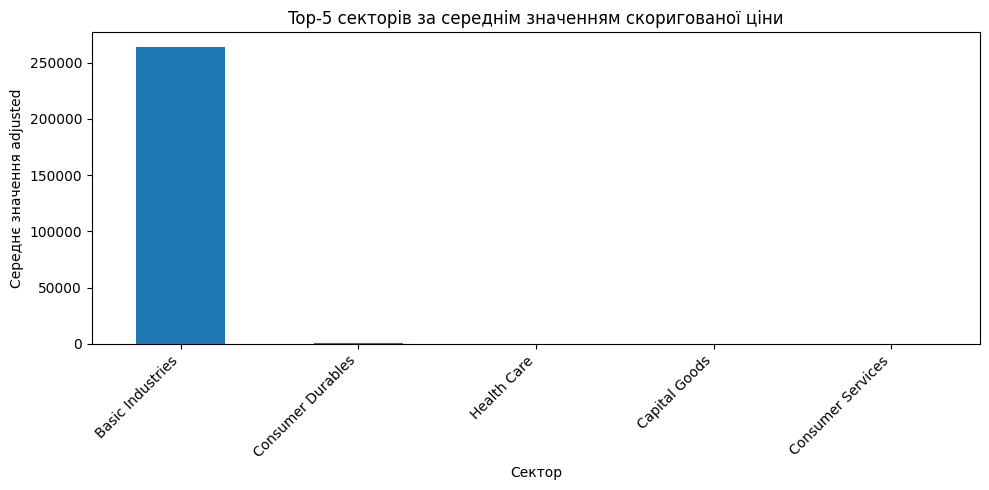

In [16]:
import matplotlib.pyplot as plt

top_df.plot(
    kind='bar',
    x='sector',
    y='avg_adjusted',
    legend=False,
    figsize=(10, 5),
    ylabel='Середнє значення adjusted',
    xlabel='Сектор',
    title='Top-5 секторів за середнім значенням скоригованої ціни'
)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

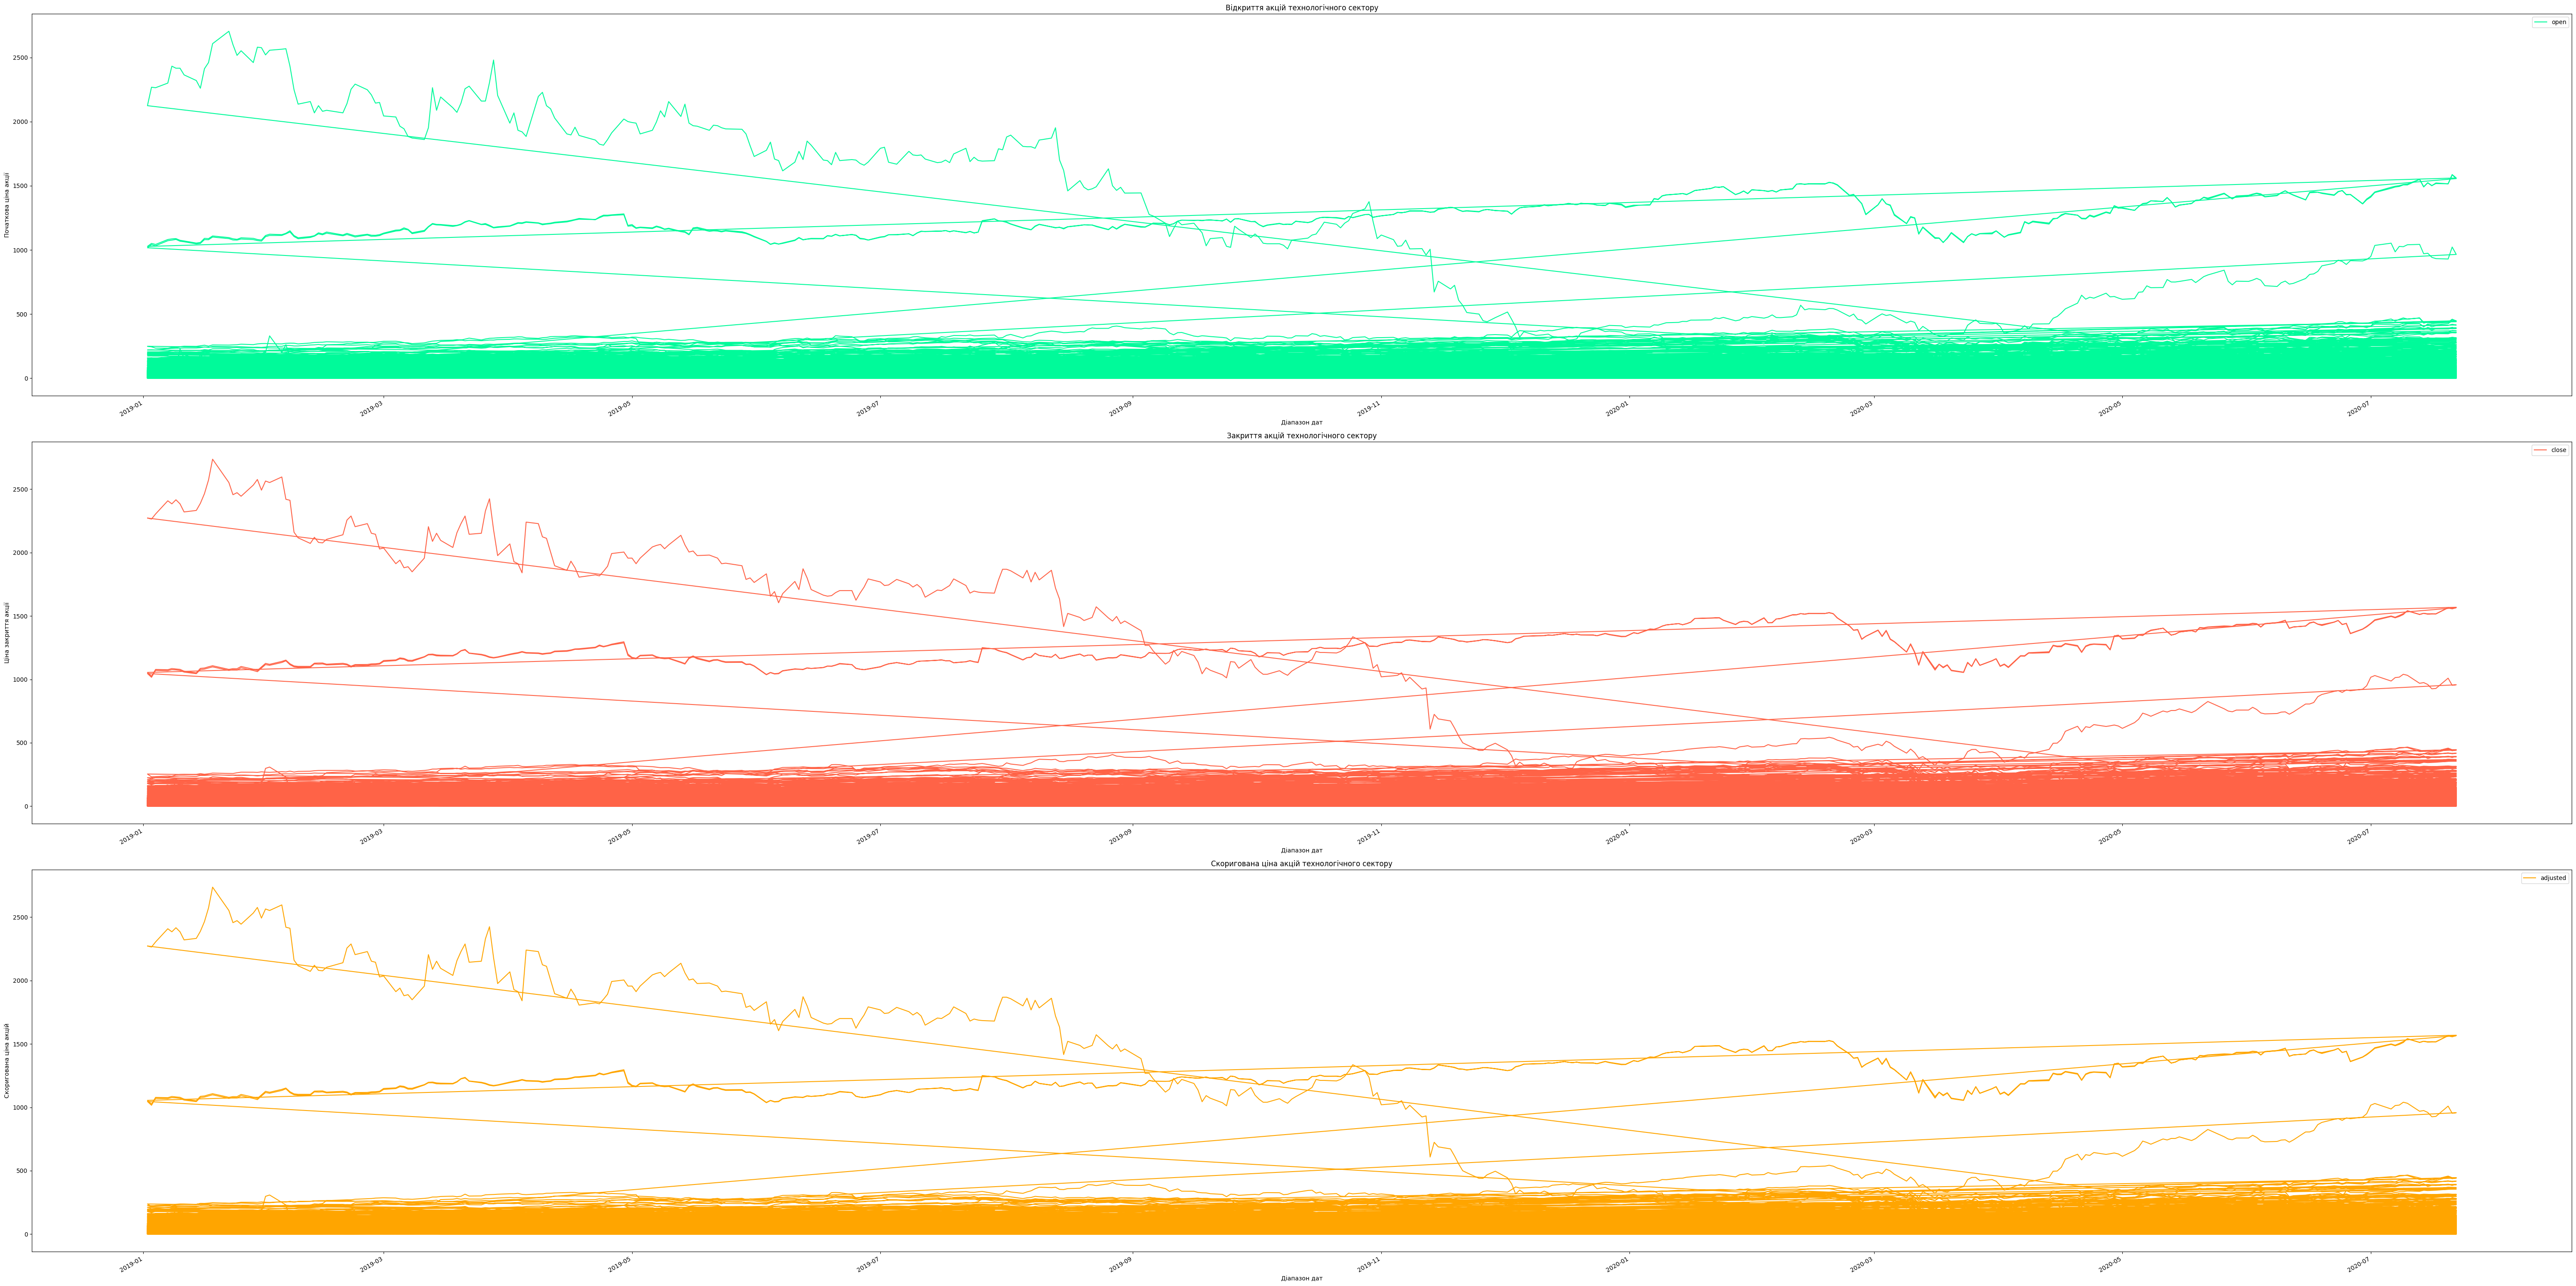

In [17]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType


tech = data.where(col('sector') == 'Technology') \
           .select('date',
                   col('open').cast(DoubleType()).alias('open'),
                   col('close').cast(DoubleType()).alias('close'),
                   col('adjusted').cast(DoubleType()).alias('adjusted'))

tech_pandas = tech.toPandas()
tech_pandas['date'] = tech_pandas['date'].astype('datetime64[ns]')

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(60, 30))

tech_pandas.plot(kind='line', x='date', y='open',
                 xlabel='Діапазон дат', ylabel='Початкова ціна акції',
                 ax=axes[0], color='mediumspringgreen', title='Відкриття акцій технологічного сектору')
tech_pandas.plot(kind='line', x='date', y='close',
                 xlabel='Діапазон дат', ylabel='Ціна закриття акції',
                 ax=axes[1], color='tomato', title='Закриття акцій технологічного сектору')
tech_pandas.plot(kind='line', x='date', y='adjusted',
                 xlabel='Діапазон дат', ylabel='Скоригована ціна акцій',
                 ax=axes[2], color='orange', title='Скоригована ціна акцій технологічного сектору')

plt.tight_layout()
plt.show()

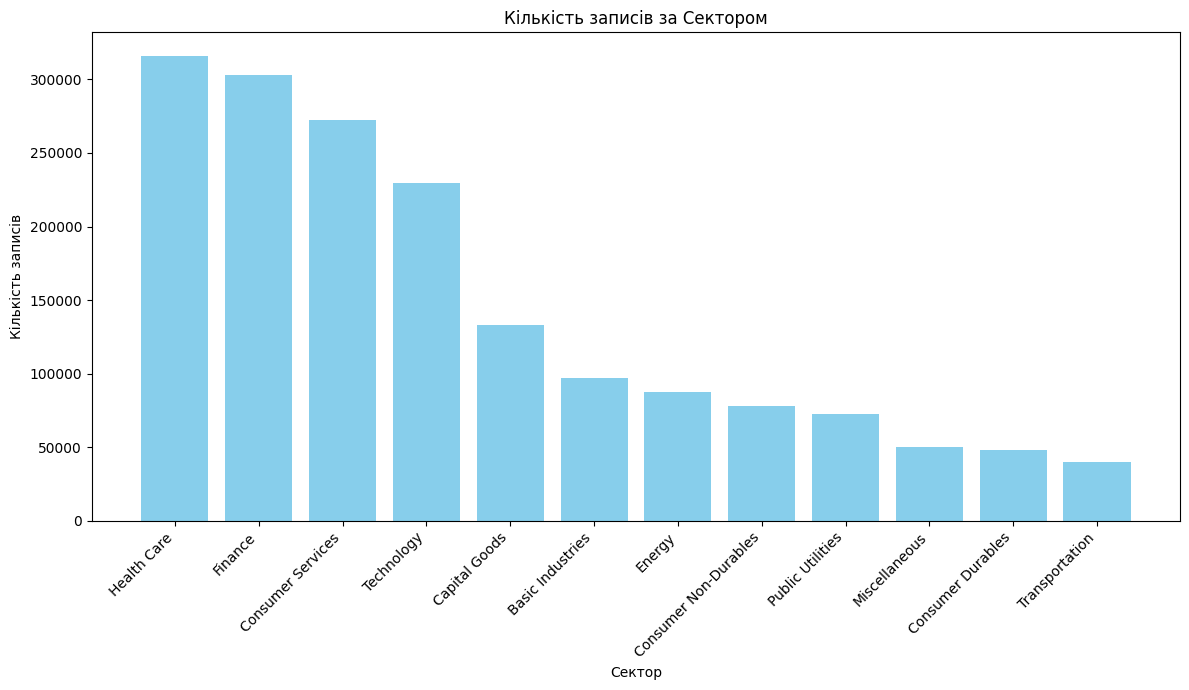

In [18]:
from pyspark.sql import functions as F

sector_counts = data.groupBy("sector").count().orderBy(F.col("count").desc())
sector_counts_pd = sector_counts.toPandas()

plt.figure(figsize=(12, 7))
plt.bar(sector_counts_pd["sector"], sector_counts_pd["count"], color='skyblue')
plt.xlabel("Сектор")
plt.ylabel("Кількість записів")
plt.title("Кількість записів за Сектором")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()